In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/vaanigupta/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Introduction to Networkx

The simple methods '.nodes()' and '.edges()' print the key components of the network.

In [2]:
HG = nx.house_graph()
HG.nodes()
HG.edges()

NodeView((0, 1, 2, 3, 4))

EdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

## Drawing the network

To draw the network, we need to give it a dictionary that maps each node to an X-Y coordinate. I give one below.

{0: Text(0, 0, '0'),
 1: Text(1, 0, '1'),
 2: Text(0, 1, '2'),
 3: Text(1, 1, '3'),
 4: Text(0.5, 2.0, '4')}

(-0.05, 1.05, -0.1, 2.1)

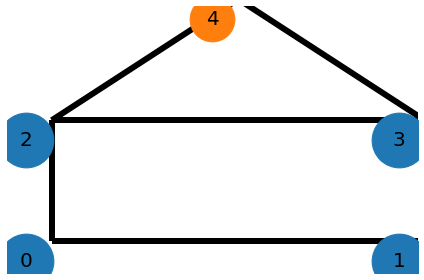

In [3]:
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

nx.draw_networkx_nodes(
    HG, pos, node_size=3000, nodelist=[0, 1, 2, 3], 
    node_color="tab:blue"
)

nx.draw_networkx_nodes(HG, pos, node_size=2000, 
                       nodelist=[4], node_color="tab:orange")

nx.draw_networkx_edges(HG, pos, alpha=1, width=6)
nx.draw_networkx_labels(HG, pos, font_size=20)
plt.tight_layout()
plt.axis("off")

In [12]:
ADJ = nx.to_pandas_adjacency(HG)
ADJ = ADJ.astype(bool)
ADJ

,0,1,2,3,4
0,False,True,True,False,False
1,True,False,False,True,False
2,True,False,False,True,True
3,False,True,True,False,True
4,False,False,True,True,False


In [5]:
deg_0 = nx.degree(HG, 0) 
deg_0

2

# Activity
We will learn how to process a dataframe into a useable edgelist to feed into a graph.

In [6]:
df = pd.read_pickle("../public_data/Raw_Tweets.pkl") # Load your tweets
df.head()
df.shape

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


(59887, 15)

### 1.1 Subset the dataframe to network data

- First, using .value_counts(), identify how many types of tweets there are, using the tweet_type column. 
- Then, filter out all tweets that are not "retweeted_tweet_without_comment" and "quoted_tweet."

In [76]:
# your code here
df["tweet_type"].value_counts()
types = ["retweeted_tweet_without_comment", "quoted_tweet"]
df_subset = df[df["tweet_type"].isin(types)]
df_subset["tweet_type"].value_counts()

tweet_type
original                           26275
retweeted_tweet_without_comment    19923
reply                               7292
quoted_tweet                        6397
Name: count, dtype: int64

tweet_type
retweeted_tweet_without_comment    19923
quoted_tweet                        6397
Name: count, dtype: int64

In [77]:
## Run this. Why is it empty?
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


### 1.2 Create an edgelist

The "userid" column shows the person that did the retweeting. Create a new column called "userid2" that denotes the user retweeted. You will need to use the columns "rt_userid" and "qtd_userid."

In [101]:
%time
import numpy as np
userids = [df_subset.iloc[i]["rt_userid"] if not np.isnan(df_subset.iloc[i]["rt_userid"]) else df_subset.iloc[i]["qtd_userid"] for i in range(df_subset.shape[0])]
df_subset["userid2"] = userids
df_subset.head()

# Alternative Approach
# tweets[‘userid2’] = tweets[‘rt_userid’].where(tweets[‘rt_userid’].notna(), tweets[‘qtd_userid’])

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 8.82 µs


<ipython-input-101-d569b05356c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["userid2"] = userids


,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid,userid2,weight
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN,9.200360e+17,-0.6597
25575,1222280171501256706,20467163,Tue Jan 28 22:07:56 +0000 2020,en,RT @RCCallihan: The declaration of a public he...,retweeted_tweet_without_comment,10261,30106,2762,"[1697808410, 146569971]",1.697808e+09,1.222247e+18,NaN,NaN,NaN,1.697808e+09,0.3182
28489,1222283902724820995,426033838,Tue Jan 28 22:22:46 +0000 2020,en,RT @DepSecHargan: Start the #NewYear off right...,retweeted_tweet_without_comment,625,1823,22314,"[920035992073064450, 146569971]",9.200360e+17,1.222239e+18,NaN,NaN,NaN,9.200360e+17,0.0000
28496,1222283757119590405,426033838,Tue Jan 28 22:22:11 +0000 2020,en,RT @CDCFlu: Elevated #flu activity is expected...,retweeted_tweet_without_comment,625,1823,22314,[16616061],1.661606e+07,1.222194e+18,NaN,NaN,NaN,1.661606e+07,0.3818
12992,1220696703667326976,426033838,Fri Jan 24 13:15:48 +0000 2020,en,RT @CDCemergency: Is it a cold or flu? What’s ...,retweeted_tweet_without_comment,625,1822,22325,[19658936],1.965894e+07,1.220488e+18,NaN,NaN,NaN,1.965894e+07,-0.4515


### 1.3 Sentiment scoring. 
- Now, use SentimentIntensityAnalyzer to label the sentiment of the text, in a new column called "weight." 
- The subset the dataframe to only have "userid", "user2", and "weight". 
- Rename "userid" to "user1", then group by "user1" and "user2", to find the mean sentiment (mean weight).

You now have your first edgelist!

In [112]:
sentiments = SentimentIntensityAnalyzer()
def get_sentiments(text):
    return sentiments.polarity_scores(text)["compound"]
df_subset["weight"] = df_subset.text.apply(get_sentiments)
df_subset.head()

<ipython-input-112-42dc2515a31e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["weight"] = df_subset.text.apply(get_sentiments)


,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid,userid2,weight
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN,9.200360e+17,-0.6597
25575,1222280171501256706,20467163,Tue Jan 28 22:07:56 +0000 2020,en,RT @RCCallihan: The declaration of a public he...,retweeted_tweet_without_comment,10261,30106,2762,"[1697808410, 146569971]",1.697808e+09,1.222247e+18,NaN,NaN,NaN,1.697808e+09,0.3182
28489,1222283902724820995,426033838,Tue Jan 28 22:22:46 +0000 2020,en,RT @DepSecHargan: Start the #NewYear off right...,retweeted_tweet_without_comment,625,1823,22314,"[920035992073064450, 146569971]",9.200360e+17,1.222239e+18,NaN,NaN,NaN,9.200360e+17,0.0000
28496,1222283757119590405,426033838,Tue Jan 28 22:22:11 +0000 2020,en,RT @CDCFlu: Elevated #flu activity is expected...,retweeted_tweet_without_comment,625,1823,22314,[16616061],1.661606e+07,1.222194e+18,NaN,NaN,NaN,1.661606e+07,0.3818
12992,1220696703667326976,426033838,Fri Jan 24 13:15:48 +0000 2020,en,RT @CDCemergency: Is it a cold or flu? What’s ...,retweeted_tweet_without_comment,625,1822,22325,[19658936],1.965894e+07,1.220488e+18,NaN,NaN,NaN,1.965894e+07,-0.4515


In [100]:
df_further_subset = df_subset[["userid", "userid2", "weight"]]
df_further_subset = df_further_subset.rename(columns={"userid": "user1", "userid2": "user2"})
df_further_subset.head()
df_further_subset.groupby(["user1", "user2"])["weight"].mean()

,user1,user2,weight
12221,418859255,9.200360e+17,-0.6597
25575,20467163,1.697808e+09,0.3182
28489,426033838,9.200360e+17,0.0000
28496,426033838,1.661606e+07,0.3818
12992,426033838,1.965894e+07,-0.4515


user1                user2       
5558312              5.558312e+06    0.7263
                     2.009386e+07    0.6705
                     2.056292e+07    0.5106
                     2.874303e+07    0.5106
                     5.090780e+07    0.8831
                                      ...  
815952318487298048   1.008376e+18    0.4404
                     1.080866e+18   -0.4019
1075205691621720064  3.382592e+09    0.0000
                     1.075206e+18    0.7717
                     1.083126e+18    0.0000
Name: weight, Length: 9370, dtype: float64

# Netwulf Visualization
#### If you don't have the module, pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [102]:
EL =  pd.read_pickle("../public_data/edge_list_final2.pkl")

In [103]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]])

In [104]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

# Creates the biggest subgraph
CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [107]:
from netwulf import visualize
import netwulf as nw

In [108]:
stylized_network, config = visualize(GG,)

In [109]:
U = pd.read_pickle("../public_data/UserInfo.pkl")
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

In [113]:
stylized_network, config = visualize(GG,port=2000)

### Activity Two
- Create a new column in U called "Degree," which denotes the degree of the node (userid). You will want to use G.degree()[n] where n is the userid.
- Group by User Type. Which group was the most popular during the pandemic?

In [115]:
# your code here.
# solution in slack chat 
U['Degree'] = U['userid'].apply(lambda x: G.degree(x) if x in G else 0)
U.head()

,userid,PlotColor,User_type,Degree
0,1079770852302950016,grey,Independent,0
1,172858784,royalblue,Democrat,5
2,48117116,firebrick,Republican,1
3,129259273,firebrick,Republican,0
4,1249982359,firebrick,Republican,80


In [119]:
U.groupby("User_type")["Degree"].mean()

User_type
Democrat           12.286408
Health Official    18.397590
Independent         0.292683
Republican          8.118483
Name: Degree, dtype: float64